# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 9, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0.15,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 5000,
                
        'interpretation_net_output_monomials': None, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 20, #Float for fraction, Int for number 0
        
        'normalize_inet_data': True,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,
    },
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)    
list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 19683


  0%|          | 0/19683 [00:00<?, ?it/s]

List length: 55
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0

In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_55_drop0.25e500b256_custom/lnets_5000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0.15bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0.15bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=20)]: Using backend MultiprocessingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=20)]: Using backend MultiprocessingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:  8.7min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
33553  1373158606            -0.278            -0.667            -0.234   
9427   1373158606            -0.131             0.830            -0.700   
199    1373158606             0.360            -0.884             0.858   
12447  1373158606             0.088            -0.031            -0.050   
39489  1373158606            -0.554            -0.054            -0.761   

       000000010-target  000000011-target  000000020-target  000000100-target  \
33553            -0.161            -0.706             0.321            -0.960   
9427             -0.436            -0.003            -0.641             0.294   
199              -0.555             0.999            -0.657             0.543   
12447             0.522             0.888             0.295            -0.280   
39489            -0.447            -0.387             0.157             0.654   

       000000101-target  000000110-target  000000200-target  000001000-target  \
33553            -0.786            -0.789            -0.921            -0.466   
9427              0.403             0.083             0.710             0.852   
199              -0.553            -0.838             0.750             0.718   
12447            -0.620            -0.300             0.503             0.331   
39489            -0.644            -0.461            -0.230             0.321   

       000001001-target  000001010-target  000001100-target  000002000-target  \
33553             0.352             0.617            -0.600             0.188   
9427              0.654             0.580             0.576            -0.798   
199              -0.193             0.405             0.114             0.706   
12447             0.966             0.092             0.814            -0.631   
39489            -0.420             0.849            -0.870             0.717   

       000010000-target  000010001-target  000010010-target  000010100-target  \
33553            -0.186             0.003             0.787             0.512   
9427              0.431            -0.042            -0.664             0.823   
199              -0.370             0.047            -0.029            -0.292   
12447            -0.748            -0.376             0.412             0.489   
39489            -0.535             0.101             0.045            -0.776   

       000011000-target  000020000-target  000100000-target  000100001-target  \
33553             0.125            -0.271            -0.022             0.009   
9427             -0.509             0.561             0.794             0.064   
199               0.783            -0.668            -0.701             0.154   
12447            -0.218             0.363            -0.265             0.302   
39489             0.610             0.906            -0.538             0.135   

       000100010-target  000100100-target  000101000-target  000110000-target  \
33553            -0.102             0.896            -0.015             0.586   
9427              0.117             0.333             0.161            -0.337   
199               0.315            -0.611            -0.219             0.893   
12447            -0.662             0.732             0.486            -0.797   
39489            -0.625            -0.707             0.256            -0.123   

       000200000-target  001000000-target  001000001-target  001000010-target  \
33553             0.246            -0.532             0.500             0.028   
9427             -0.032            -0.438             0.936             0.499   
199              -0.507             0.337             0.480            -0.104   
12447             0.512            -0.421             0.605            -0.775   
39489             0.346             0.688            -0.276             0.955   

       001000100-target  001001000-target  001010000-target  001100000-target  \
33553            -0.403             0.341             0.372             

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  000000000-target  000000001-target  000000002-target  \
count       5000.000          5000.000          5000.000          5000.000   
mean  1373158606.000             0.005             0.005            -0.011   
std            0.000             0.583             0.570             0.573   
min   1373158606.000            -1.000            -1.000            -1.000   
25%   1373158606.000            -0.508            -0.475            -0.511   
50%   1373158606.000             0.003             0.008            -0.014   
75%   1373158606.000             0.517             0.489             0.483   
max   1373158606.000             1.000             0.999             1.000   

       000000010-target  000000011-target  000000020-target  000000100-target  \
count          5000.000          5000.000          5000.000          5000.000   
mean             -0.011            -0.014             0.010            -0.005   
std               0.573             0.578             0.582             0.579   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.505            -0.516            -0.490            -0.507   
50%              -0.022            -0.017             0.022            -0.017   
75%               0.480             0.491             0.527             0.499   
max               0.999             1.000             1.000             1.000   

       000000101-target  000000110-target  000000200-target  000001000-target  \
count          5000.000          5000.000          5000.000          5000.000   
mean              0.001            -0.009             0.008             0.001   
std               0.580             0.582             0.571             0.580   
min              -0.999            -0.999            -1.000            -1.000   
25%              -0.506            -0.514            -0.486            -0.481   
50%              -0.006            -0.016            -0.003            -0.002   
75%               0.510             0.496             0.502             0.501   
max               1.000             1.000             0.999             1.000   

       000001001-target  000001010-target  000001100-target  000002000-target  \
count          5000.000          5000.000          5000.000          5000.000   
mean              0.006            -0.008             0.002             0.016   
std               0.585             0.579             0.583             0.578   
min              -0.999            -0.999            -1.000            -1.000   
25%              -0.492            -0.505            -0.512            -0.479   
50%               0.005            -0.010             0.007             0.023   
75%               0.516             0.488             0.512             0.521   
max               1.000             1.000             1.000             1.000   

       000010000-target  000010001-target  000010010-target  000010100-target  \
count          5000.000          5000.000          5000.000          5000.000   
mean             -0.011             0.003            -0.015             0.001   
std               0.583             0.575             0.575             0.577   
min              -0.999            -1.000            -1.000            -1.000   
25%              -0.507            -0.498            -0.522            -0.501   
50%              -0.014             0.009            -0.008            -0.004   
75%               0.487             0.501             0.483             0.508   
max               1.000             1.000             0.999             1.000   

       000011000-target  000020000-target  000100000-target  000100001-target  \
count          5000.000          5000.000          5000.000          5000.000   
mean             -0.010            -0.008             0.002            -0.006   
std               0.575             0.572             0.579             0.577   
min              -1.000            -1.000            -1.000          

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.73082941, 0.05213017, 0.66572068, 0.87712713, 0.06067624,
        0.09081775, 0.72254459, 0.20717409, 0.4915632 ],
       [0.624057  , 0.90447014, 0.92468088, 0.93750586, 0.65198702,
        0.44290109, 0.35719106, 0.71362528, 0.38521999],
       [0.20728853, 0.3990572 , 0.23764756, 0.50852175, 0.94043697,
        0.8591    , 0.34855253, 0.87088499, 0.99980287],
       [0.58654567, 0.8845656 , 0.90932963, 0.90834534, 0.62394553,
        0.8081525 , 0.91104895, 0.75970973, 0.96291015],
       [0.8217497 , 0.33359407, 0.6376189 , 0.62417853, 0.67121809,
        0.66421107, 0.52845012, 0.51743737, 0.97099857],
       [0.60145068, 0.17803421, 0.38437711, 0.67995954, 0.98294559,
        0.52212317, 0.62965456, 0.13924224, 0.75433468],
       [0.7222318 , 0.81118147, 0.21146383, 0.56395218, 0.82417586,
        0.83460542, 0.3015649 , 0.88933477, 0.25549277],
       [0.73541227, 0.09589284, 0.53089947, 0.84096981, 0.90104095,
        0.86411768, 0.26617861, 0.48882316, 0.82097931],


In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-1.13771771],
       [ 0.47982393],
       [-0.42441769],
       [-0.91328845],
       [ 0.04898086],
       [-0.48349864],
       [ 1.47318748],
       [ 1.01904184],
       [ 0.77653566],
       [-0.80453525]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset = lambda_net_dataset_without_noise

            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(50000, 3192)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4980, 3192)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(20, 3192)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
33553  1373158606            -0.278            -0.667            -0.234   
9427   1373158606            -0.131             0.830            -0.700   
199    1373158606             0.360            -0.884             0.858   
12447  1373158606             0.088            -0.031            -0.050   
39489  1373158606            -0.554            -0.054            -0.761   

       000000010-target  000000011-target  000000020-target  000000100-target  \
33553            -0.161            -0.706             0.321            -0.960   
9427             -0.436            -0.003            -0.641             0.294   
199              -0.555             0.999            -0.657             0.543   
12447             0.522             0.888             0.295            -0.280   
39489            -0.447            -0.387             0.157             0.654   

       000000101-target  000000110-target  000000200-target  000001000-target  \
33553            -0.786            -0.789            -0.921            -0.466   
9427              0.403             0.083             0.710             0.852   
199              -0.553            -0.838             0.750             0.718   
12447            -0.620            -0.300             0.503             0.331   
39489            -0.644            -0.461            -0.230             0.321   

       000001001-target  000001010-target  000001100-target  000002000-target  \
33553             0.352             0.617            -0.600             0.188   
9427              0.654             0.580             0.576            -0.798   
199              -0.193             0.405             0.114             0.706   
12447             0.966             0.092             0.814            -0.631   
39489            -0.420             0.849            -0.870             0.717   

       000010000-target  000010001-target  000010010-target  000010100-target  \
33553            -0.186             0.003             0.787             0.512   
9427              0.431            -0.042            -0.664             0.823   
199              -0.370             0.047            -0.029            -0.292   
12447            -0.748            -0.376             0.412             0.489   
39489            -0.535             0.101             0.045            -0.776   

       000011000-target  000020000-target  000100000-target  000100001-target  \
33553             0.125            -0.271            -0.022             0.009   
9427             -0.509             0.561             0.794             0.064   
199               0.783            -0.668            -0.701             0.154   
12447            -0.218             0.363            -0.265             0.302   
39489             0.610             0.906            -0.538             0.135   

       000100010-target  000100100-target  000101000-target  000110000-target  \
33553            -0.102             0.896            -0.015             0.586   
9427              0.117             0.333             0.161            -0.337   
199               0.315            -0.611            -0.219             0.893   
12447            -0.662             0.732             0.486            -0.797   
39489            -0.625            -0.707             0.256            -0.123   

       000200000-target  001000000-target  001000001-target  001000010-target  \
33553             0.246            -0.532             0.500             0.028   
9427             -0.032            -0.438             0.936             0.499   
199              -0.507             0.337             0.480            -0.104   
12447             0.512            -0.421             0.605            -0.775   
39489             0.346             0.688            -0.276             0.955   

       001000100-target  001001000-target  001010000-target  001100000-target  \
33553            -0.403             0.341             0.372             

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
33675  1373158606             0.295             0.424             0.292   
37218  1373158606             0.959             0.454            -0.059   
26722  1373158606            -0.709            -0.145            -0.335   
4850   1373158606            -0.619            -0.876            -0.325   
24317  1373158606            -0.600            -0.349             0.541   

       000000010-target  000000011-target  000000020-target  000000100-target  \
33675             0.214            -0.507             0.239            -0.208   
37218             0.832            -0.982             0.167            -0.999   
26722             0.263             0.709             0.843             0.504   
4850              0.243            -0.537            -0.573            -0.034   
24317             0.082            -0.272            -0.463            -0.540   

       000000101-target  000000110-target  000000200-target  000001000-target  \
33675            -0.624            -0.732             0.709             0.401   
37218             0.283            -0.464             0.401             0.990   
26722             0.152            -0.291             0.142            -0.281   
4850              0.143            -0.858             0.423            -0.930   
24317             0.262            -0.966             0.342            -0.432   

       000001001-target  000001010-target  000001100-target  000002000-target  \
33675            -0.556             0.415            -0.517            -0.042   
37218             0.408            -0.497            -0.113            -0.632   
26722            -0.769             0.400            -0.159             0.538   
4850             -0.788            -0.999            -0.869            -0.537   
24317             0.539             0.327             0.334             0.289   

       000010000-target  000010001-target  000010010-target  000010100-target  \
33675             0.442            -0.426             0.658            -0.497   
37218             0.007            -0.596            -0.231            -0.563   
26722             0.003             0.474             0.762             0.029   
4850             -0.250             0.233             0.953             0.058   
24317             0.696            -0.025             0.297            -0.585   

       000011000-target  000020000-target  000100000-target  000100001-target  \
33675             0.424            -0.061             0.539             0.177   
37218             0.085             0.555            -0.429             0.579   
26722             0.471             0.289             0.064            -0.159   
4850              0.619            -0.032             0.577             0.367   
24317             0.070             0.993             0.494             0.021   

       000100010-target  000100100-target  000101000-target  000110000-target  \
33675            -0.920            -0.619            -0.853            -0.351   
37218            -0.368            -0.767            -0.231             0.523   
26722             0.162             0.153            -0.396            -0.521   
4850              0.178            -0.122             0.774            -0.677   
24317            -0.756             0.010            -0.593            -0.074   

       000200000-target  001000000-target  001000001-target  001000010-target  \
33675             0.487            -0.239             0.884             0.887   
37218             0.964             0.977             0.482             0.862   
26722             0.980             0.949            -0.255             0.182   
4850              0.122             0.802            -0.755            -0.302   
24317             0.858             0.549             0.893            -0.338   

       001000100-target  001001000-target  001010000-target  001100000-target  \
33675            -0.840             0.586             0.784            -

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
34234  1373158606            -0.659             0.026            -0.843   
28241  1373158606            -0.477            -0.725             0.534   
1226   1373158606             0.279             0.337             0.376   
27004  1373158606            -0.084            -0.093             0.960   
35839  1373158606            -0.328            -0.125             0.570   

       000000010-target  000000011-target  000000020-target  000000100-target  \
34234             0.270             0.091            -0.358            -0.722   
28241             0.754             0.762            -0.526             0.990   
1226              0.665            -0.702            -0.899            -0.941   
27004             0.635            -0.977             0.887             0.534   
35839            -0.333             0.033            -0.356            -0.792   

       000000101-target  000000110-target  000000200-target  000001000-target  \
34234             0.203             0.324            -0.035             0.401   
28241             0.765            -0.774             0.916            -0.036   
1226             -0.792            -0.242             0.935            -0.294   
27004            -0.690             0.803             0.381             0.123   
35839            -0.997             0.706            -0.784             0.678   

       000001001-target  000001010-target  000001100-target  000002000-target  \
34234             0.422            -0.819            -0.216             0.223   
28241             0.786             0.169             0.787            -0.291   
1226             -0.094             0.629             0.837             0.943   
27004             0.578             0.303             0.169             0.644   
35839             0.529             0.427            -0.374            -0.598   

       000010000-target  000010001-target  000010010-target  000010100-target  \
34234            -0.949            -0.354             0.625            -0.920   
28241            -0.332             0.803             0.762            -0.417   
1226              0.653             0.005            -0.541             0.197   
27004            -0.401            -0.387            -0.478            -0.358   
35839            -0.351             0.734            -0.453             0.590   

       000011000-target  000020000-target  000100000-target  000100001-target  \
34234            -0.577            -0.367             0.559            -0.798   
28241            -0.456            -0.637            -0.526             0.484   
1226             -0.606            -0.889             0.839            -0.030   
27004             0.981            -0.800            -0.468             0.987   
35839             0.697             0.283            -0.692             0.234   

       000100010-target  000100100-target  000101000-target  000110000-target  \
34234             0.707            -0.540             0.114            -0.986   
28241             0.054            -0.381            -0.976            -0.275   
1226              0.016             0.218            -0.097            -0.111   
27004             0.339             0.412            -0.906            -0.595   
35839             0.647             0.276            -0.719            -0.101   

       000200000-target  001000000-target  001000001-target  001000010-target  \
34234            -0.085            -0.770             0.305             0.770   
28241             0.148             0.908             0.363             0.259   
1226              0.830             0.633            -0.575            -0.416   
27004             0.821            -0.832             0.288             0.802   
35839             0.686             0.231            -0.689            -0.488   

       001000100-target  001001000-target  001010000-target  001100000-target  \
34234             0.839             0.009            -0.193             

## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   19.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   23.8s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   32.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   42.7s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   57.4s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed:  3.0min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed:  3.6min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed:  4.2min
[Parallel(n_jobs=20)]: Done 8410 tasks      | elapsed:  4.9min
[Parallel(n_jobs=20)]: Done 9760 tasks      | elapsed:  5.6min
[Parallel(n_jobs=20)]: Done 11210 tasks      

Epoch 1/500
196/196 [==============================] - 120s 577ms/step - loss: 0.1981 - r2_inet_coefficient_loss: 0.0082 - r2_inet_lambda_fv_loss: 1.0431 - mae_inet_coefficient_loss: 0.4750 - mae_inet_lambda_fv_loss: 0.1981 - val_loss: 0.1063 - val_r2_inet_coefficient_loss: -0.0090 - val_r2_inet_lambda_fv_loss: -0.4440 - val_mae_inet_coefficient_loss: 0.4843 - val_mae_inet_lambda_fv_loss: 0.1064
Epoch 2/500
196/196 [==============================] - 105s 537ms/step - loss: 0.0962 - r2_inet_coefficient_loss: -0.0207 - r2_inet_lambda_fv_loss: -0.5292 - mae_inet_coefficient_loss: 0.4673 - mae_inet_lambda_fv_loss: 0.0962 - val_loss: 0.0858 - val_r2_inet_coefficient_loss: -0.0260 - val_r2_inet_lambda_fv_loss: -0.6331 - val_mae_inet_coefficient_loss: 0.4801 - val_mae_inet_lambda_fv_loss: 0.0858
Epoch 3/500
196/196 [==============================] - 106s 543ms/step - loss: 0.0777 - r2_inet_coefficient_loss: -0.0341 - r2_inet_lambda_fv_loss: -0.6903 - mae_inet_coefficient_loss: 0.4640 - mae_in

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 105s 534ms/step - loss: 0.0495 - r2_inet_coefficient_loss: -0.0843 - r2_inet_lambda_fv_loss: -0.8729 - mae_inet_coefficient_loss: 0.4515 - mae_inet_lambda_fv_loss: 0.0495 - val_loss: 0.0476 - val_r2_inet_coefficient_loss: -0.0797 - val_r2_inet_lambda_fv_loss: -0.8833 - val_mae_inet_coefficient_loss: 0.4661 - val_mae_inet_lambda_fv_loss: 0.0476
Epoch 28/500
196/196 [==============================] - 105s 535ms/step - loss: 0.0490 - r2_inet_coefficient_loss: -0.0875 - r2_inet_lambda_fv_loss: -0.8750 - mae_inet_coefficient_loss: 0.4506 - mae_inet_lambda_fv_loss: 0.0490 - val_loss: 0.0494 - val_r2_inet_coefficient_loss: -0.0825 - val_r2_inet_lambda_fv_loss: -0.8749 - val_mae_inet_coefficient_loss: 0.4654 - val_mae_inet_lambda_fv_loss: 0.0494
Epoch 29/500
196/196 [==============================] - 105s 538ms/step - loss: 0.0484 - r2_inet_coefficient_loss: -0.0901 - r2_inet_lambda_fv_loss: -0.8783 - mae_inet_coefficient_loss: 0.4498 - mae_inet_lambd

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 105s 536ms/step - loss: 0.0415 - r2_inet_coefficient_loss: -0.1501 - r2_inet_lambda_fv_loss: -0.9108 - mae_inet_coefficient_loss: 0.4343 - mae_inet_lambda_fv_loss: 0.0415 - val_loss: 0.0404 - val_r2_inet_coefficient_loss: -0.1448 - val_r2_inet_lambda_fv_loss: -0.9166 - val_mae_inet_coefficient_loss: 0.4488 - val_mae_inet_lambda_fv_loss: 0.0404
Epoch 52/500
196/196 [==============================] - 105s 536ms/step - loss: 0.0414 - r2_inet_coefficient_loss: -0.1521 - r2_inet_lambda_fv_loss: -0.9112 - mae_inet_coefficient_loss: 0.4336 - mae_inet_lambda_fv_loss: 0.0414 - val_loss: 0.0406 - val_r2_inet_coefficient_loss: -0.1462 - val_r2_inet_lambda_fv_loss: -0.9161 - val_mae_inet_coefficient_loss: 0.4484 - val_mae_inet_lambda_fv_loss: 0.0406
Epoch 53/500
196/196 [==============================] - 105s 536ms/step - loss: 0.0411 - r2_inet_coefficient_loss: -0.1538 - r2_inet_lambda_fv_loss: -0.9126 - mae_inet_coefficient_loss: 0.4334 - mae_inet_lambd

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 104s 533ms/step - loss: 0.0379 - r2_inet_coefficient_loss: -0.1794 - r2_inet_lambda_fv_loss: -0.9259 - mae_inet_coefficient_loss: 0.4264 - mae_inet_lambda_fv_loss: 0.0379 - val_loss: 0.0366 - val_r2_inet_coefficient_loss: -0.1727 - val_r2_inet_lambda_fv_loss: -0.9317 - val_mae_inet_coefficient_loss: 0.4412 - val_mae_inet_lambda_fv_loss: 0.0366
Epoch 79/500
196/196 [==============================] - 104s 532ms/step - loss: 0.0380 - r2_inet_coefficient_loss: -0.1801 - r2_inet_lambda_fv_loss: -0.9252 - mae_inet_coefficient_loss: 0.4260 - mae_inet_lambda_fv_loss: 0.0380 - val_loss: 0.0364 - val_r2_inet_coefficient_loss: -0.1724 - val_r2_inet_lambda_fv_loss: -0.9323 - val_mae_inet_coefficient_loss: 0.4413 - val_mae_inet_lambda_fv_loss: 0.0365
Epoch 80/500
196/196 [==============================] - 104s 533ms/step - loss: 0.0379 - r2_inet_coefficient_loss: -0.1808 - r2_inet_lambda_fv_loss: -0.9259 - mae_inet_coefficient_loss: 0.4259 - mae_inet_lambd

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.5min finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.5min finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.4min finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  1.3min finished


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:05:50
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
[[-1.0537176  -0.12406174 -1.5657674  ...  0.09994347 -0.8136877
  -2.193637  ]
 [ 1.3432938   0.8216803   5.2977448  ...  0.6709917   2.3969321
   1.6195457 ]
 [ 1.4846027   1.5498633   4.8372455  ...  3.0653017   2.8996313
   0.8395874 ]
 ...
 [ 2.9177434   3.0345905   4.229005   ...  4.338263    1.7882859
   3.501507  ]
 [ 1.8330925   1.5406665   2.5438867  ...  3.4308305   2.3528807
   2.0462708 ]
 [ 1.250093   -0.653286    0.90814275 ... -1.425

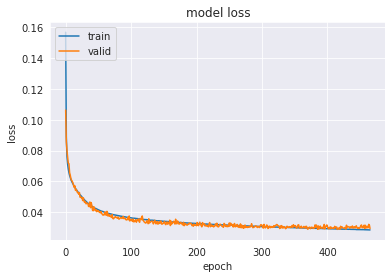

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [76]:
history_list[-1]['loss'][-1]

0.02850235626101494

In [77]:
history_list[-1]['val_loss'][-1]

0.029405537992715836

In [24]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials'])

In [25]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [26]:
poly_optimize

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54.], dtype=float32)>

In [27]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [28]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3026)]            0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               1549824   
_________________________________________________________________
dropout1_0.25 (Dropout)      (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
output_1024 (Dense)          (None, 55)                56375     
Total params: 2,131,511
Trainable params: 2,131,511
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 3026), 'dtype':

In [29]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [30]:
scores_test_list[-1]

MAE  RMSE  MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN   NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN   NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN   NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.063 0.094 0.349   
target_polynomials_VS_lstsq_target_polynomials     0.018 0.024 0.102   
target_polynomials_VS_inet_polynomials             0.204 0.265 0.990   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.060 0.091 0.597   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.191 0.247 1.250   
lstsq_target_polynomials_VS_inet_polynomials       0.205 0.266 1.656   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.519   
target_polynomials_VS_lstsq_target_polynomials         0.834   
target_polynomials_VS_inet_polynomials                 0.181   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.535   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.184   
lstsq_target_polynomials_VS_inet_polynomials           0.176   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    0.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.038    0.050    0.131   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.035    0.046    0.120   
lambda_preds_VS_lstsq_target_polynomials             0.037    0.049    0.125   
lambda_preds_VS_inet_polynomials                     0.190    0.231    0.540   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.023    0.030    0.081   
target_polynomials_VS_lstsq_target_polynomials       0.008    0.011    0.033   
target_polynomials_VS_inet_polynomials               0.190    0.232    0.565   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.022    0.029    0.118   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.186    0.227    0.725   
lstsq_target_polynomials_VS_inet_polynomials         0.189    0.231    0.533   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.998    0.036    0.223   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.998    0.034    0.204   
lambda_preds_VS_lstsq_target_polynomials            0.998    0.035    0.222   
lambda_preds_VS_inet_polynomials                    0.947    0.180    0.602   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.999    0.023    0.123   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.008    0.040   
target_polynomials_VS_inet_polynomials              0.946    0.180    0.679   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.999    0.022    0.086   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.948    0.176    0.650   
lstsq_target_polynomials_VS_inet_polynomials        0.946 

In [31]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.039 0.038 0.034 0.042   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.036 0.039 0.034 0.039   
lambda_preds_VS_lstsq_target_polynomials           0.039 0.039 0.034 0.042   
lambda_preds_VS_inet_polynomials                   0.207 0.294 0.157 0.177   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.023 0.025 0.021 0.025   
target_polynomials_VS_lstsq_target_polynomials     0.007 0.008 0.006 0.007   
target_polynomials_VS_inet_polynomials             0.207 0.291 0.151 0.172   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.024 0.025 0.020 0.024   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.202 0.297 0.147 0.168   
lstsq_target_polynomials_VS_inet_polynomials       0.206 0.289 0.151 0.173   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.037 0.041 0.038 0.035   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.034 0.034 0.037 0.036   
lambda_preds_VS_lstsq_target_polynomials           0.036 0.039 0.038 0.034   
lambda_preds_VS_inet_polynomials                   0.125 0.210 0.205 0.151   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.023 0.025 0.023 0.020   
target_polynomials_VS_lstsq_target_polynomials     0.008 0.009 0.007 0.007   
target_polynomials_VS_inet_polynomials             0.122 0.219 0.205 0.148   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.023 0.021 0.023 0.018   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.119 0.209 0.198 0.150   
lstsq_target_polynomials_VS_inet_polynomials       0.123 0.218 0.205 0.148   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.040 0.035 0.037 0.036   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.036 0.035 0.033 0.034   
lambda_preds_VS_lstsq_target_polynomials           0.040 0.034 0.038 0.036   
lambda_preds_VS_inet_polynomials                   0.138 0.179 0.117 0.126   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.028 0.020 0.025 0.023   
target_polynomials_VS_lstsq_target_polynomials     0.009 0.008 0.008 0.009   
target_polynomials_VS_inet_polynomials             0.140 0.173 0.120 0.126   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.027 0.019 0.025 0.023   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.133 0.175 0.109 0.120   
lstsq_target_polynomials_VS_inet_polynomials       0.142 0.173 0.119 0.126   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.038 0.034 0.039 0.037   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.035 0.032 0.034 0.036   
lambda_preds_VS_lstsq_target_polynomials           0.036 0.032 0.038 0.036   
lambda_preds_VS_inet_polynomials                   0.156 0.198 0.196 0.190   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.025 0.022 0.024 0.020   
target_polynomials_VS_lstsq_target_polynomials     0.010 0.010 0.009 0.009   
target_polynomials_VS_inet_polynomials             0.158 0.194 0.200 0.190   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.022 0.018 0.023 0.018   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.150 0.200 0.191 0.184   
lstsq_target_polynomials_VS_inet_polynomials       0.157 0.194 0.199 0.189   

                                                    L-16  L-17  L-18  L-19  
lambda_preds_VS_target_polynomials                 0.033 0.042 0.041 0.035  
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.029 0.039 0.037 0.032  
lambda_preds_VS_lstsq_target_polynomials           0.032 0.042 0.040 0.034  
lambda_preds_VS_inet_polynomials                   0.200 0.212 0.388 0.168  
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.021 0.032 0.026 0.022  
target_polynomials_VS_lstsq_target_polynomials     0.008 0.007 0.009 0.009  
target_polynomials_VS_inet_polynomials             0.204 0.211 0.400 0.162  
l

In [32]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.997 0.999 0.998 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.998 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.999 0.998 0.998   
lambda_preds_VS_inet_polynomials                   0.937 0.946 0.963 0.959   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 1.000 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.936 0.948 0.964 0.961   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 1.000 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.938 0.945 0.966 0.962   
lstsq_target_polynomials_VS_inet_polynomials       0.936 0.949 0.964 0.961   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.997 0.998 0.998 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.999 0.998 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.998 0.998 0.998   
lambda_preds_VS_inet_polynomials                   0.970 0.952 0.951 0.967   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.972 0.948 0.951 0.968   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.972 0.952 0.954 0.967   
lstsq_target_polynomials_VS_inet_polynomials       0.971 0.949 0.951 0.968   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.998 0.999 0.993 0.997   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.995 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.998 0.999 0.993 0.997   
lambda_preds_VS_inet_polynomials                   0.975 0.976 0.937 0.967   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 1.000 0.997 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.974 0.977 0.933 0.967   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 1.000 0.997 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.976 0.976 0.941 0.969   
lstsq_target_polynomials_VS_inet_polynomials       0.973 0.977 0.933 0.967   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.998 0.999 0.999 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.999 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.998 0.999 0.999 0.998   
lambda_preds_VS_inet_polynomials                   0.968 0.965 0.969 0.949   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 1.000 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.967 0.965 0.968 0.949   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 1.000 1.000 1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.971 0.963 0.970 0.952   
lstsq_target_polynomials_VS_inet_polynomials       0.968 0.965 0.968 0.949   

                                                    L-16  L-17  L-18  L-19  
lambda_preds_VS_target_polynomials                 0.998 0.997 0.996 0.998  
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.999 0.998 0.997 0.998  
lambda_preds_VS_lstsq_target_polynomials           0.998 0.997 0.996 0.998  
lambda_preds_VS_inet_polynomials                   0.943 0.949 0.742 0.951  
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.998 0.999  
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000  
target_polynomials_VS_inet_polynomials             0.941 0.950 0.732 0.954  
l

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9945339081303894


-0.74751621200015*a**2 + 0.233002739977273*a*b + 0.815767457858758*a*c - 0.957165932862884*a*d + 0.310648017499971*a*e + 0.714101286102198*a*f - 0.18256568780509*a*g + 0.177830452975876*a*h + 0.435489953393154*a*i - 0.689745340908124*a - 0.401304640635226*b**2 + 0.319051387454488*b*c + 0.1738220551618*b*d + 0.236735077148466*b*e - 0.26412327705924*b*f - 0.338090340944683*b*g + 0.467526802763235*b*h - 0.20055007332317*b*i - 0.640137552592932*b - 0.929315438541874*c**2 + 0.726903725136685*c*d + 0.204242180594222*c*e + 0.011679804855743*c*f + 0.859086096481287*c*g + 0.760759756219615*c*h + 0.397477359186204*c*i + 0.137864027790678*c + 0.197548858296848*d**2 - 0.716307805133832*d*e - 0.720309528502883*d*f + 0.541076686614459*d*g + 0.242800923256439*d*h - 0.330198123359675*d*i + 0.618365042745095*d - 0.0424476079662867*e**2 + 0.544655842144322*e*f - 0.522467910446111*e*g + 0.222460336262154*e*h - 0.748935294416761*e*i - 0.0045338503782014*e + 0.34282331131984*f**2 - 0.0023997599599728*f*g -

In [34]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.9468431720709016 (20 Samples)
Mean (only positive): 0.9468431720709016 (20 Samples)


In [35]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9979739235489085 (20 Samples)
Mean (only positive): 0.9979739235489085 (20 Samples)


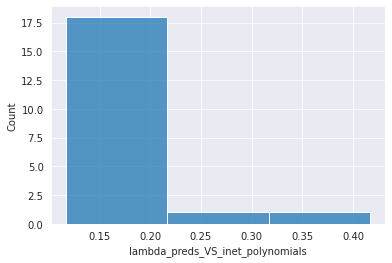

In [36]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

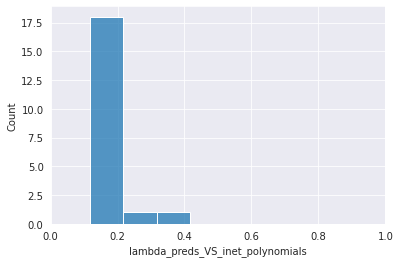

In [37]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


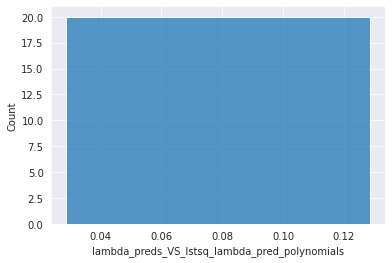

In [38]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

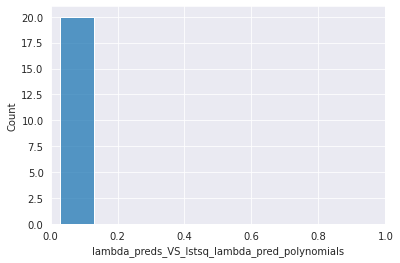

In [39]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


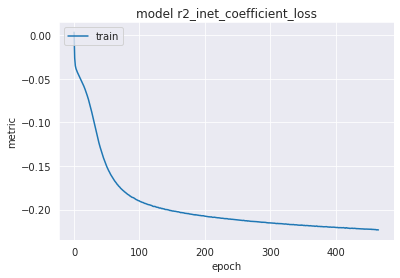

In [40]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


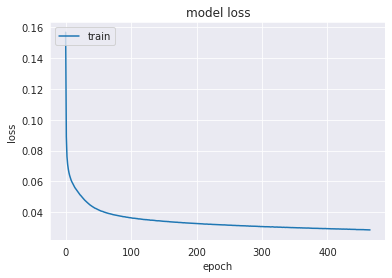

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [42]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [43]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [44]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [45]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.4292*a**2 + 0.6544*a*b - 0.35*a*c - 0.7941*a*d - 0.1521*a*e - 0.8497*a*f - 0.5111*a*g - 0.4548*a*h + 0.5846*a*i - 1.0073*a - 0.257*b**2 - 0.846*b*c - 0.6709*b*d + 0.0003*b*e - 0.8775*b*f - 0.4389*b*g + 0.5138*b*h - 0.0143*b*i - 0.96*b - 0.0108*c**2 + 0.718*c*d - 0.702*c*e + 0.5644*c*f + 0.4517*c*g + 0.358*c*h - 0.6641*c*i - 0.5163*c - 0.9331*d**2 - 0.4172*d*e + 0.7343*d*f - 0.092*d*g + 0.8221*d*h + 0.8896*d*i + 0.8555*d + 0.259*e**2 + 0.5435*e*f - 0.3534*e*g - 0.5978*e*h - 0.7998*e*i - 0.9543*e - 0.0858*f**2 - 0.535*f*g + 0.3185*f*h - 0.1445*f*i + 0.6846*f - 0.5062*g**2 + 0.0757*g*h - 0.7962*g*i - 0.6991*g - 0.4438*h**2 + 0.5659*h*i - 0.9527*h + 0.4998*i**2 - 0.7007*i + 0.9884

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.3584*a**2 + 0.7082*a*b - 0.399*a*c - 0.828*a*d - 0.1975*a*e - 0.9387*a*f - 0.5248*a*g - 0.5271*a*h + 0.5823*a*i - 0.8181*a - 0.2739*b**2 - 0.8945*b*c - 0.7479*b*d - 0.0217*b*e - 0.9164*b*f - 0.4587*b*g + 0.5039*b*h - 0.0384*b*i - 0.8687*b - 0.0677*c**2 + 0.7551*c*d - 0.7885*c*e + 0.5803*c*f + 0.4376*c*g + 0.3134*c*h - 0.751*c*i - 0.2897*c - 0.9565*d**2 - 0.4575*d*e + 0.7515*d*f - 0.1461*d*g + 0.8089*d*h + 0.8928*d*i + 0.9837*d + 0.2567*e**2 + 0.5192*e*f - 0.4015*e*g - 0.6482*e*h - 0.9101*e*i - 0.7376*e - 0.0935*f**2 - 0.497*f*g + 0.3092*f*h - 0.1816*f*i + 0.7277*f - 0.5569*g**2 + 0.0816*g*h - 0.887*g*i - 0.5273*g - 0.3993*h**2 + 0.6045*h*i - 0.8995*h + 0.5725*i**2 - 0.6044*i + 0.683

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.352*a**2 + 0.6997*a*b - 0.408*a*c - 0.8255*a*d - 0.2125*a*e - 0.9602*a*f - 0.5043*a*g - 0.4989*a*h + 0.5849*a*i - 0.8193*a - 0.2786*b**2 - 0.9322*b*c - 0.7266*b*d - 0.0184*b*e - 0.8973*b*f - 0.4493*b*g + 0.531*b*h - 0.0355*b*i - 0.8852*b - 0.0555*c**2 + 0.761*c*d - 0.7821*c*e + 0.5748*c*f + 0.4383*c*g + 0.3084*c*h - 0.7418*c*i - 0.2805*c - 0.9438*d**2 - 0.4534*d*e + 0.7988*d*f - 0.15*d*g + 0.7847*d*h + 0.8786*d*i + 0.9594*d + 0.2261*e**2 + 0.4918*e*f - 0.3993*e*g - 0.6365*e*h - 0.9231*e*i - 0.6947*e - 0.1026*f**2 - 0.4982*f*g + 0.3024*f*h - 0.1762*f*i + 0.7314*f - 0.5608*g**2 + 0.096*g*h - 0.8511*g*i - 0.573*g - 0.3908*h**2 + 0.6152*h*i - 0.9465*h + 0.5534*i**2 - 0.6034*i + 0.7112

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.290800005197525*a**2 + 0.404799997806549*a*b - 0.444099992513657*a*c - 0.683000028133392*a*d - 0.432300001382828*a*e - 0.710099995136261*a*f - 0.878899991512299*a*g - 0.656499981880188*a*h + 0.328000009059906*a*i - 0.294900000095367*a - 0.267899990081787*b**2 - 0.71670001745224*b*c - 0.587000012397766*b*d - 0.0192000009119511*b*e - 0.52240002155304*b*f - 0.476700007915497*b*g + 0.323100000619888*b*h - 0.125799998641014*b*i - 0.747200012207031*b + 0.0463000014424324*c**2 + 0.269699990749359*c*d - 0.617399990558624*c*e + 0.245299994945526*c*f + 0.5382000207901*c*g - 0.00609999988228083*c*h - 0.535300016403198*c*i - 0.321999996900558*c - 0.325500011444092*d**2 - 0.437799990177155*d*e + 0.622699975967407*d*f - 0.165700003504753*d*g + 0.62169998884201*d*h + 0.74370002746582*d*i + 0.220699995756149*d + 0.149299994111061*e**2 + 0.573000013828278*e*f - 0.405400007963181*e*g - 0.66049998998642*e*h - 0.869599997997284*e*i - 0.640399992465973*e + 0.138099998235703*f**2 - 0.426400005817413*f*g +

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


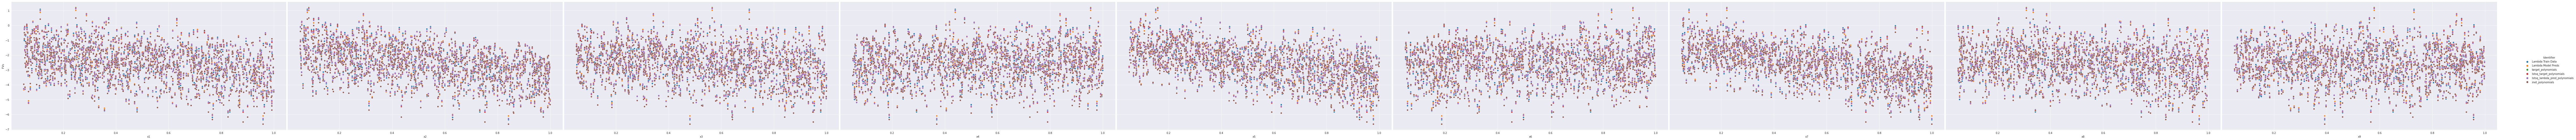

In [46]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

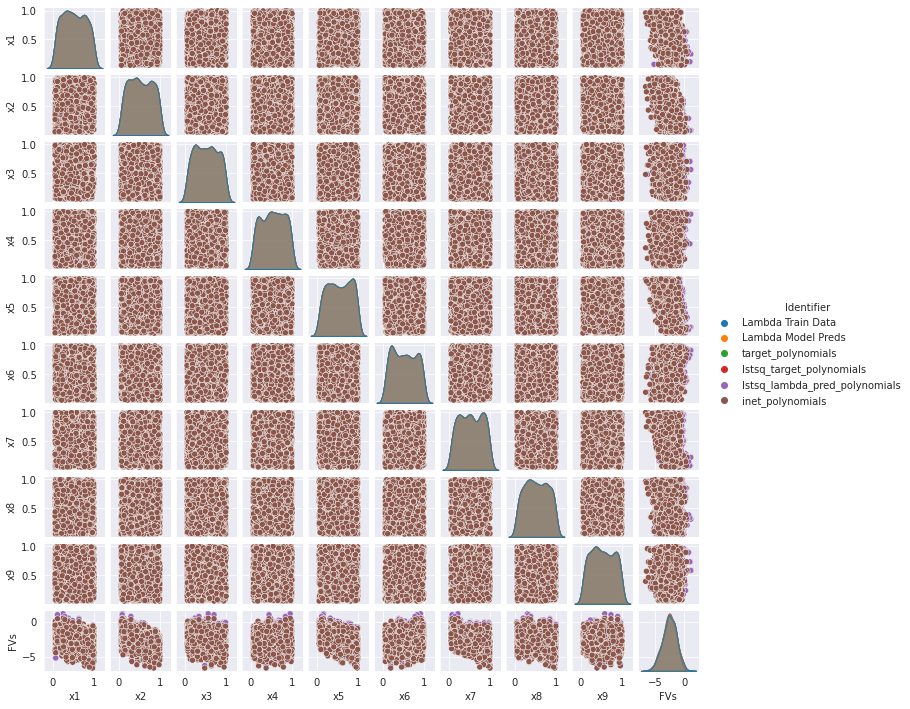

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

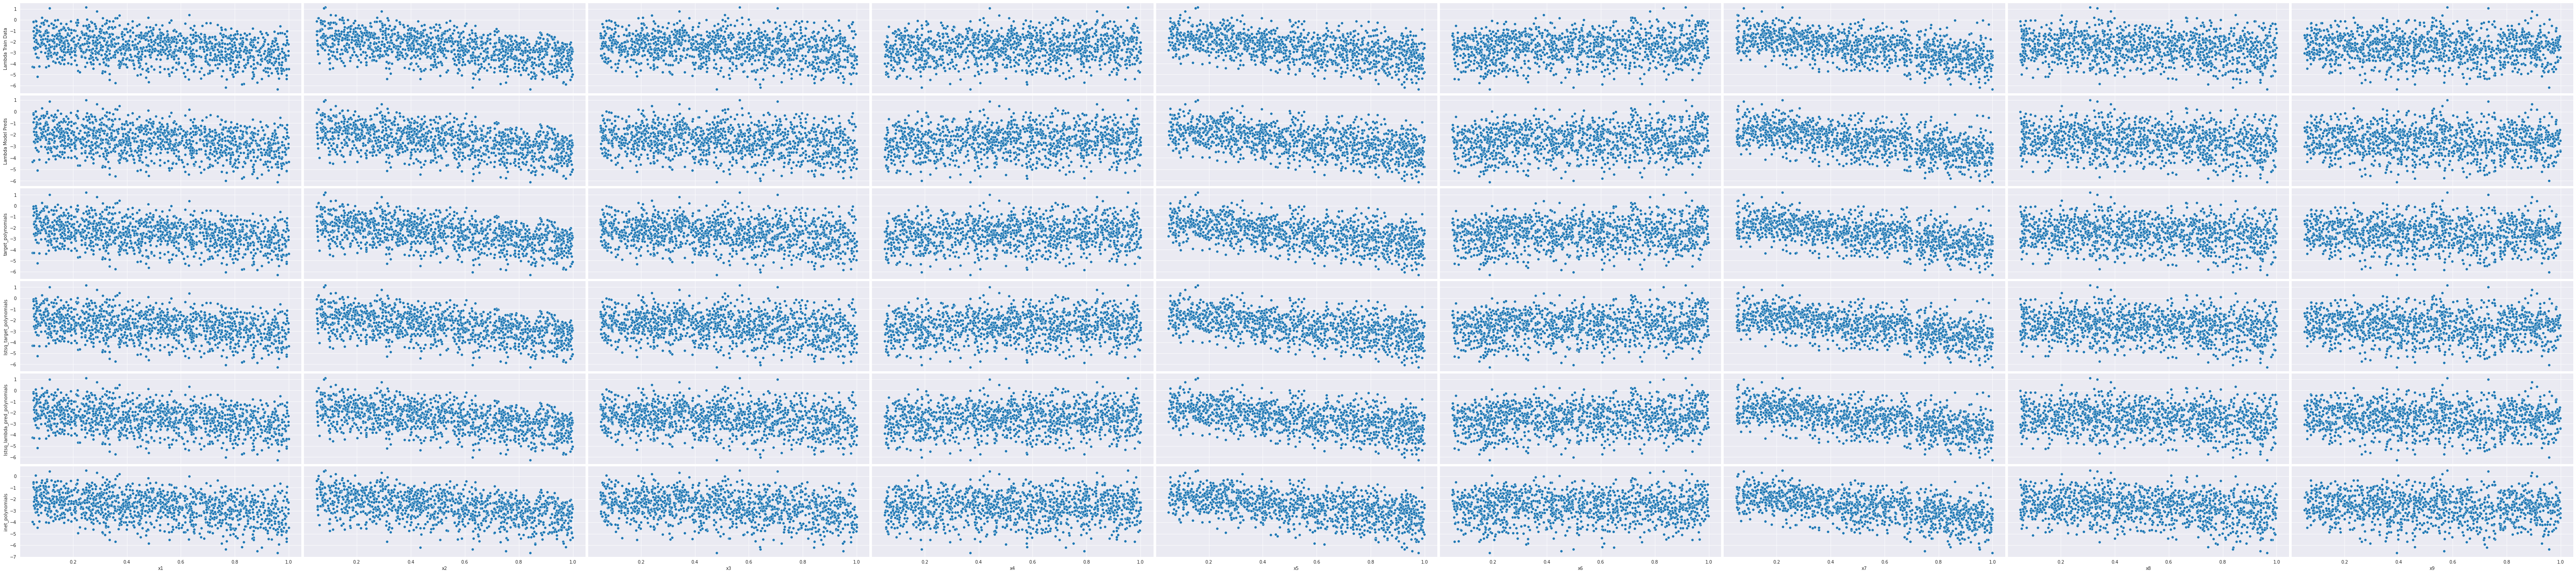

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [49]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [50]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.3min finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.3min finished


In [51]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.8938


In [52]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 13.8653


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [53]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.3min finished


In [54]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.4816


In [55]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [56]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.9769318699836731 
 Curr_res: 1.41898775100708 
 Iteration 1, Step 15
Optimization terminated at 0.9769318699836731


array([ 0.32689053, -0.6065084 , -0.3041217 , -0.44829845,  0.11547436,
        0.1979632 , -0.51784664, -0.29070273, -0.39938313, -0.01218191,
        0.38087782, -0.46628124, -0.36640552,  0.2673867 , -0.56586576,
       -0.44681448,  0.02641778,  0.05541477,  0.21027544, -0.17117712,
        0.03076062,  0.02058245, -0.07883133, -0.3612805 ,  0.29933798,
       -0.16831742,  0.0998365 ,  0.11010768,  0.05058543, -0.4173997 ,
        0.07848793, -0.39034832,  0.28428873,  0.03239951,  0.0489966 ,
       -0.00276625,  0.2757913 , -0.3219207 , -0.23331547,  0.25675628,
       -0.07352372,  0.0923972 , -0.34199244, -0.2469583 , -0.07537186,
        0.1106158 , -0.16591331, -0.04174414,  0.02355924, -0.37886745,
       -0.01536261, -0.3554634 , -0.15099561,  0.05011491, -0.02988979],
      dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [57]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
0      1.000         0.618       0.457   0.536         0.238       0.000   
1      1.000         0.729       0.647   0.590         0.208       0.000   
2      1.000         0.646       0.565   0.517         0.179       0.000   
3      1.000         0.610       0.565   0.516         0.238       0.000   
4      1.000         0.605       0.511   0.521         0.149       0.000   

   Europe  Japan   USA  
0   0.000  0.000 1.000  
1   0.000  0.000 1.000  
2   0.000  0.000 1.000  
3   0.000  0.000 1.000  
4   0.000  0.000 1.000

In [58]:
#%load_ext autoreload

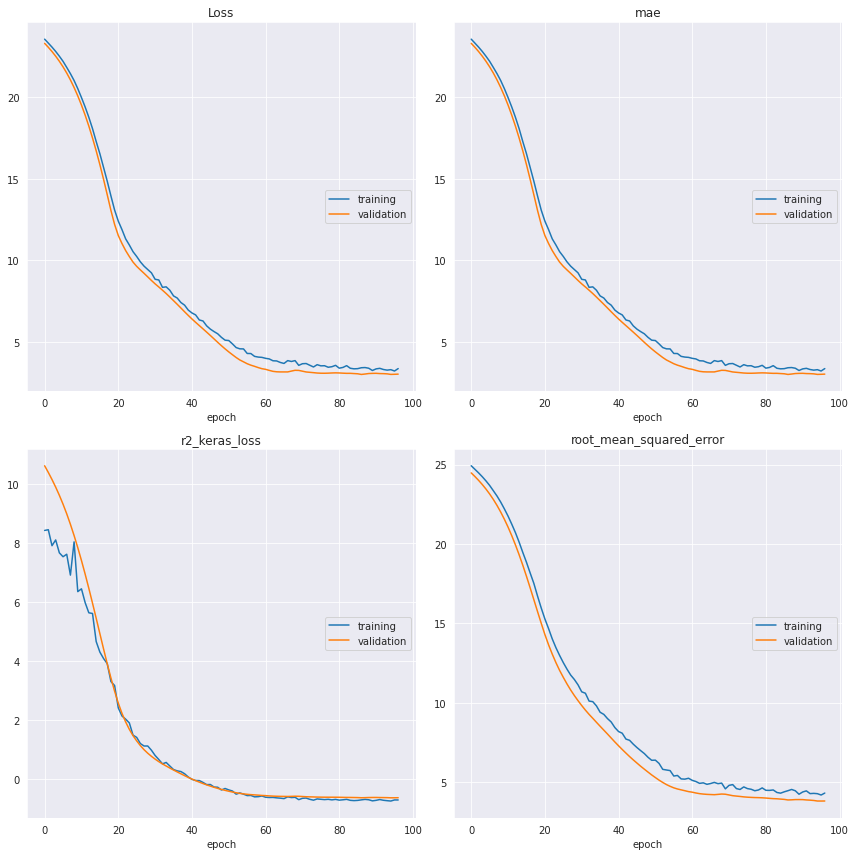

Loss
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
mae
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
r2_keras_loss
	training         	 (min:   -0.739, max:    8.463, cur:   -0.702)
	validation       	 (min:   -0.629, max:   10.632, cur:   -0.626)
root_mean_squared_error
	training         	 (min:    4.182, max:   24.931, cur:    4.306)
	validation       	 (min:    3.803, max:   24.481, cur:    3.805)


In [59]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [60]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [61]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [62]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


25.2286539480068*a**2 + 34.0287139550307*a*b + 18.0932570499931*a*c + 25.6485669178858*a*d + 11.8356985637181*a*e + 28.4174665068772*a*f + 22.312311477323*a*g + 31.2097232156447*a*h + 15.2985191803865*a*i + 10.4762538668444*a + 14.8978754312047*b**2 + 26.3572224222291*b*c + 34.2483464499565*b*d + 27.2326405851262*b*e + 13.5408922912164*b*f + 10.3428910762516*b*g + 14.5209934753284*b*h + 20.422211908195*b*i + 15.954733133596*b + 35.6469998184674*c**2 + 12.0777219588615*c*d + 35.1331433092717*c*e + 21.0078435055443*c*f + 23.0491621639872*c*g + 15.4149978936722*c*h + 26.3612584739928*c*i + 30.0733921149539*c + 15.6029296372462*d**2 + 26.7506871749194*d*e + 26.006074979453*d*f + 27.5268291110638*d*g + 11.135540926069*d*h + 34.6302369713652*d*i + 40.1212238582529*d + 15.5541409493661*e**2 + 31.5773655681719*e*f + 24.7182947609047*e*g + 34.5726896812036*e*h + 19.4181911667596*e*i + 30.2665247147964*e + 27.9886524802845*f**2 + 29.0009753281196*f*g + 19.4200131051318*f*h + 27.4544430490185*f*i

MAE Model:  0.15916017529428483
MAE Data:  3.250696253893852
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [63]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


2.09646248817444*a**2 - 0.293801844120026*a*b - 2.93526220321655*a*c - 0.752157330513*a*d - 1.41048943996429*a*e - 1.91732752323151*a*f + 0.0741718932986259*a*g - 0.922982275485992*a*h - 0.981393337249756*a*i - 0.579734206199646*a - 0.249765753746033*b**2 - 0.627483665943146*b*c - 0.235106825828552*b*d - 1.91018152236938*b*e + 0.281629383563995*b*f - 0.372991263866425*b*g + 0.648365616798401*b*h + 0.239039897918701*b*i - 0.53820413351059*b + 1.60559546947479*c**2 - 0.616598784923553*c*d - 0.894153416156769*c*e - 0.257285416126251*c*f + 1.07154762744904*c*g - 0.20220659673214*c*h - 0.000777325127273798*c*i + 0.348445326089859*c + 1.06373238563538*d**2 + 0.0545788109302521*d*e + 2.08950400352478*d*f - 1.45334732532501*d*g + 0.44363084435463*d*h + 0.956436693668365*d*i - 1.75231051445007*d + 0.868889808654785*e**2 + 1.17989385128021*e*f - 0.532058298587799*e*g - 2.47766399383545*e*h + 0.519222915172577*e*i + 0.0812585726380348*e + 0.242601528763771*f**2 - 0.606322944164276*f*g - 1.5266553

MAE Model:  9.437650653675531
MAE Data:  8.63530641225591
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [64]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 0.6496659517288208 
 Curr_res: 0.6524602174758911 
 Iteration 2, Step 450
Optimization terminated at 0.6091649532318115
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.461753368377686*a**2 - 1.89270520210266*a*b - 1.9220107793808*a*c - 2.36398649215698*a*d - 0.686269402503967*a*e - 0.805770456790924*a*f - 0.480718672275543*a*g + 0.0308452863246202*a*h - 1.5617800951004*a*i + 3.93710374832153*a - 1.11875867843628*b**2 - 1.69425702095032*b*c - 2.00124382972717*b*d - 0.781262993812561*b*e - 1.0262907743454*b*f - 0.846341907978058*b*g - 0.775681138038635*b*h - 1.27628362178802*b*i + 3.55218505859375*b - 0.868202865123749*c**2 - 1.90501773357391*c*d - 0.619940400123596*c*e - 0.721471667289734*c*f - 0.646418035030365*c*g - 0.472360849380493*c*h - 1.64161264896393*c*i + 4.45387554168701*c - 0.691526114940643*d**2 - 0.928329229354858*d*e - 0.694056749343872*d*f - 0.745304226875305*d*g - 0.688530802726746*d*h - 1.65770447254181*d*i + 3.26282739639282*d + 2.72592949867249*e**2 + 1.66887557506561*e*f + 1.67281889915466*e*g + 1.98716986179352*e*h + 0.773875594139099*e*i + 6.01716613769531*e + 2.90022349357605*f**2 + 2.07680535316467*f*g + 2.09302687644958*f*h

MAE Model:  1.4938927138076943
MAE Data:  3.3586613270163057
Computation Time: 0:02:01
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [65]:
#%load_ext autoreload

In [66]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.26          75376.8       31          17.1493           16.679      2.59m
   1    10.77          30.8964       19          7.64499          7.60779      1.81m
   2    16.44          28.6539        7          5.63116          5.67009      1.86m
   3    22.61          26.2427       11          3.77382          3.54974      1.96m
   4    24.38          26.1236       27          3.66047          4.11925      1.88m
   5    24.27          28.3932       37          3.16534          3.10417      1.89m
   6    25.07          26.2236       37          2.96932          3.23797      1.71m
   7    25.94          28.6484       47          2.74389          2.61233      1.56m
   8    25.88           37.037       43          2.15818           2.5221  

-2.572*X1 - X2 - 1.8758389261745*X3 + 10.0671140939597*X4 + 11.2607540200892*X5 + 9.71140939597315*X6 + 11.0671140939597*X7 + 4.35570469798658*X8 + 8.16152249898653

MAE Model:  0.8519412532146543
MAE Data:  3.3930433767223254
Computation Time: 0:02:51
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [67]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

---- Tuning the basis functions ----


  0%|          | 0/9 [00:00<?, ?it/s]

----  Optimizing the metamodel  ----


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(0.220096844127837*exp(-0.186721113522898*X0**2*X1**2 - 0.135257915646318*X0**2*X2**2 - 0.247831034740409*X0**2*X3**2 - 0.0429184637600559*X0**2*X4**2 + 0.122171873850546*X0**2*X5**2 - 0.111598302759871*X0**2*X6**2 + 0.0174196632779028*X0**2*X7**2 - 0.214951313449075*X0**2*X8**2 + 1.53382278307619*X0**2 + 1.78835815904025*X0*X1 + 1.23277926852691*X0*X2 + 2.10132839927241*X0*X3 + 0.499800501481204*X0*X4 - 1.38402648410247*X0*X5 + 1.31983375228957*X0*X6 - 0.193217011730341*X0*X7 + 2.23807013217128*X0*X8 - 0.438834516155076*X0 - 0.255444817023303*X1**2*X2**2 - 0.30639767260681*X1**2*X3**2 - 0.0153275585085175*X1**2*X4**2 - 0.083070291458762*X1**2*X5**2 - 0.10106590331847*X1**2*X6**2 + 0.0597824863194701*X1**2*X7**2 - 0.126679634032459*X1**2*X8**2 + 1.82450661669192*X1**2 + 2.46012182740256*X1*X2 + 2.89280747554609*X1*X3 + 0.178398894855991*X1*X4 + 0.918892741654333*X1*X5 + 1.15097079703496*X1*X6 - 0.681525437165116*X1*X7 + 1.30426129580641*X1*X8 - 3.53764193837161*X1 - 0.238651555324023

MAE Model:  22.229872003358118
MAE Data:  21.70714712967909
Computation Time: 0:00:56
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [68]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [69]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


2.09646248817444*a**2 - 0.293801844120026*a*b - 2.93526220321655*a*c - 0.752157330513*a*d - 1.41048943996429*a*e - 1.91732752323151*a*f + 0.0741718932986259*a*g - 0.922982275485992*a*h - 0.981393337249756*a*i - 0.579734206199646*a - 0.249765753746033*b**2 - 0.627483665943146*b*c - 0.235106825828552*b*d - 1.91018152236938*b*e + 0.281629383563995*b*f - 0.372991263866425*b*g + 0.648365616798401*b*h + 0.239039897918701*b*i - 0.53820413351059*b + 1.60559546947479*c**2 - 0.616598784923553*c*d - 0.894153416156769*c*e - 0.257285416126251*c*f + 1.07154762744904*c*g - 0.20220659673214*c*h - 0.000777325127273798*c*i + 0.348445326089859*c + 1.06373238563538*d**2 + 0.0545788109302521*d*e + 2.08950400352478*d*f - 1.45334732532501*d*g + 0.44363084435463*d*h + 0.956436693668365*d*i - 1.75231051445007*d + 0.868889808654785*e**2 + 1.17989385128021*e*f - 0.532058298587799*e*g - 2.47766399383545*e*h + 0.519222915172577*e*i + 0.0812585726380348*e + 0.242601528763771*f**2 - 0.606322944164276*f*g - 1.5266553

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.461753368377686*a**2 - 1.89270520210266*a*b - 1.9220107793808*a*c - 2.36398649215698*a*d - 0.686269402503967*a*e - 0.805770456790924*a*f - 0.480718672275543*a*g + 0.0308452863246202*a*h - 1.5617800951004*a*i + 3.93710374832153*a - 1.11875867843628*b**2 - 1.69425702095032*b*c - 2.00124382972717*b*d - 0.781262993812561*b*e - 1.0262907743454*b*f - 0.846341907978058*b*g - 0.775681138038635*b*h - 1.27628362178802*b*i + 3.55218505859375*b - 0.868202865123749*c**2 - 1.90501773357391*c*d - 0.619940400123596*c*e - 0.721471667289734*c*f - 0.646418035030365*c*g - 0.472360849380493*c*h - 1.64161264896393*c*i + 4.45387554168701*c - 0.691526114940643*d**2 - 0.928329229354858*d*e - 0.694056749343872*d*f - 0.745304226875305*d*g - 0.688530802726746*d*h - 1.65770447254181*d*i + 3.26282739639282*d + 2.72592949867249*e**2 + 1.66887557506561*e*f + 1.67281889915466*e*g + 1.98716986179352*e*h + 0.773875594139099*e*i + 6.01716613769531*e + 2.90022349357605*f**2 + 2.07680535316467*f*g + 2.09302687644958*f*h

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


-0.0101610841826315*a**2 + 0.0610718578665193*a*b + 0.0392276594457492*a*c + 0.0495285069394801*a*d - 0.0691341730412754*a*e - 0.0798658987280924*a*f - 0.00938757226654796*a*g - 0.0292498400796044*a*h - 0.0358372611208055*a*i - 1.62547338028931*a + 0.0470167612481587*b**2 + 0.0172055565186422*b*c + 0.101784714898919*b*d - 0.0947672393339908*b*e - 0.0831109232225001*b*f - 0.0720460651097261*b*g - 0.0528087416280731*b*h - 0.0317607564587626*b*i - 2.91017881067807*b + 0.0363924697509526*c**2 + 0.0607934382175406*c*d - 0.0553290870436242*c*e - 0.093828214075813*c*f - 0.0524776583394473*c*g - 0.0231551835834485*c*h - 0.00552175302961389*c*i - 1.52406140289448*c + 0.0819524024647262*d**2 - 0.103311683253685*d*e - 0.113378801671597*d*f - 0.0803490201314929*d*g - 0.0586461907568427*d*h - 0.0270910112731908*d*i - 3.24548728512967*d + 0.0588527690117862*e**2 + 0.0998024766036924*e*f + 0.101213800906104*e*g + 0.0565247630717884*e*h + 0.0340528404472021*e*i + 10.1508605136043*e + 0.076090446649592

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


-2.572*X1 - X2 - 1.8758389261745*X3 + 10.0671140939597*X4 + 11.2607540200892*X5 + 9.71140939597315*X6 + 11.0671140939597*X7 + 4.35570469798658*X8 + 8.16152249898653

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(0.220096844127837*exp(-0.186721113522898*X0**2*X1**2 - 0.135257915646318*X0**2*X2**2 - 0.247831034740409*X0**2*X3**2 - 0.0429184637600559*X0**2*X4**2 + 0.122171873850546*X0**2*X5**2 - 0.111598302759871*X0**2*X6**2 + 0.0174196632779028*X0**2*X7**2 - 0.214951313449075*X0**2*X8**2 + 1.53382278307619*X0**2 + 1.78835815904025*X0*X1 + 1.23277926852691*X0*X2 + 2.10132839927241*X0*X3 + 0.499800501481204*X0*X4 - 1.38402648410247*X0*X5 + 1.31983375228957*X0*X6 - 0.193217011730341*X0*X7 + 2.23807013217128*X0*X8 - 0.438834516155076*X0 - 0.255444817023303*X1**2*X2**2 - 0.30639767260681*X1**2*X3**2 - 0.0153275585085175*X1**2*X4**2 - 0.083070291458762*X1**2*X5**2 - 0.10106590331847*X1**2*X6**2 + 0.0597824863194701*X1**2*X7**2 - 0.126679634032459*X1**2*X8**2 + 1.82450661669192*X1**2 + 2.46012182740256*X1*X2 + 2.89280747554609*X1*X3 + 0.178398894855991*X1*X4 + 0.918892741654333*X1*X5 + 1.15097079703496*X1*X6 - 0.681525437165116*X1*X7 + 1.30426129580641*X1*X8 - 3.53764193837161*X1 - 0.238651555324023

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [70]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [71]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [72]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
[array([[ 1.0167775 , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
      dtype=float32), array([-0.16888502,  0.        ,  0.        ,  0.        ,  0.        ],
      dtype=float32), array([[ 1.562712  , -0.02688342, -0.01456122],
       [-0.42922467,  0.40037042,  0.67994815],
       [ 0.77379066,  0.4318593 , -0.26109576],
       [ 0.08172262, -0.41291407,  0.3418085 ],
  

In [73]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_94 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
[array([[13.799208  , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
      dtype=float32), array([0.0819062, 0.       , 0.       , 0.       , 0.       ],
      dtype=float32), array([[14.5386095 , -0.02688342, -0.01456132],
       [-0.42922467,  0.40037042,  0.67994815],
       [ 0.77379066,  0.4318593 , -0.26109576],
       [ 0.08172262, -0.41291407,  0.3418085 ],
       [-0.6

In [74]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_97 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.11970227, -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
      dtype=float32), array([31.566597,  0.      ,  0.      ,  0.      ,  0.      ],
      dtype=float32), array([[ 4.3192453 , -0.02688342, -0.01456229],
       [-0.42922467,  0.40037042,  0.67994815],
       [ 0.77379066,  0.4318593 , -0.26109576],
       [ 0.08172262, -0.41291407,  0.3418085 ],
       [-0.6

In [75]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

NameError: name 'model_2' is not defined

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()